# Set-up & Initializations

In [2]:
#We will make a basic CNN model to classify CIFAR-100#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


2.10.1


In [3]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1932771522719847319
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6047302433054561796
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Train-Test split

In [4]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print("x_train= ", x_train.shape)
print("y_train= ", y_train.shape)
print("x_test= ", x_test.shape)
print("y_test= ", y_test.shape)

#Each class has 500 samples in the training set. We will delete 10% of the samples (50) from each class
#Delete 10% of each of the training set but equally from each class
#Get the number of classes
num_classes = len(np.unique(y_train))

#Get the number of samples in each class
num_samples = x_train.shape[0] / num_classes

#Get the number of samples to delete from each class
num_samples_delete = int(num_samples * 0.1)

#Get the indices of the samples to delete
indices = []

for i in range(num_classes):
    indices.append(np.where(y_train == i)[0][:num_samples_delete])

indices = np.concatenate(indices)

#Delete the samples
x_train_uniform = np.delete(x_train, indices, axis=0)
y_train_uniform = np.delete(y_train, indices, axis=0)

#show the shape of the dataset
print("x_train_uniform= ", x_train_uniform.shape)
print("y_train_uniform= ", y_train_uniform.shape)
#show how many train data is there for each class
unique, counts = np.unique(y_train_uniform, return_counts=True)
print(dict(zip(unique, counts)))


#Another set of training data will be created by deleting 20% of the first 50 classes
#Get the number of samples to delete from each class
num_samples_delete = int(num_samples * 0.2)

#Get the indices of the samples to delete
indices = []

for i in range(50):
    indices.append(np.where(y_train == i)[0][:num_samples_delete])

indices = np.concatenate(indices)

#Delete the samples
x_train_half = np.delete(x_train, indices, axis=0)
y_train_half = np.delete(y_train, indices, axis=0)

#show the shape of the dataset
print("x_train_half= ", x_train_half.shape)
print("y_train_half= ", y_train_half.shape)

#show how many train data is there for each class
unique, counts = np.unique(y_train_half, return_counts=True)
print(dict(zip(unique, counts)))




x_train=  (50000, 32, 32, 3)
y_train=  (50000, 1)
x_test=  (10000, 32, 32, 3)
y_test=  (10000, 1)
x_train_uniform=  (45000, 32, 32, 3)
y_train_uniform=  (45000, 1)
{0: 450, 1: 450, 2: 450, 3: 450, 4: 450, 5: 450, 6: 450, 7: 450, 8: 450, 9: 450, 10: 450, 11: 450, 12: 450, 13: 450, 14: 450, 15: 450, 16: 450, 17: 450, 18: 450, 19: 450, 20: 450, 21: 450, 22: 450, 23: 450, 24: 450, 25: 450, 26: 450, 27: 450, 28: 450, 29: 450, 30: 450, 31: 450, 32: 450, 33: 450, 34: 450, 35: 450, 36: 450, 37: 450, 38: 450, 39: 450, 40: 450, 41: 450, 42: 450, 43: 450, 44: 450, 45: 450, 46: 450, 47: 450, 48: 450, 49: 450, 50: 450, 51: 450, 52: 450, 53: 450, 54: 450, 55: 450, 56: 450, 57: 450, 58: 450, 59: 450, 60: 450, 61: 450, 62: 450, 63: 450, 64: 450, 65: 450, 66: 450, 67: 450, 68: 450, 69: 450, 70: 450, 71: 450, 72: 450, 73: 450, 74: 450, 75: 450, 76: 450, 77: 450, 78: 450, 79: 450, 80: 450, 81: 450, 82: 450, 83: 450, 84: 450, 85: 450, 86: 450, 87: 450, 88: 450, 89: 450, 90: 450, 91: 450, 92: 450, 93: 450,

In [4]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

## Model Training

In [5]:
#Build model for uniform train data (train_uniform)

model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(100, activation='softmax'))

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         7

In [6]:
#Build model for half train data (train_half)
model2 = Sequential()

# Block 1
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))

# Block 5
model2.add(Dense(100, activation='softmax'))

# Print the model summary
model2.summary()

# model2 = tf.keras.models.clone_model(model)
# model2.set_weights(model.get_weights())
# model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)        

### Model1 (Uniform Distribution of Train Data) without Label Smoothing

In [7]:
#Compile the model without Label Smoothing
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + "Model1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_uniform, y_train_uniform, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every 
train_loss = history.history['loss']
val_loss = history.history['val_loss']



Epoch 1/40


c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 [==============================] - 13s 6ms/step - loss: 4.3382 - accuracy: 0.0309 - val_loss: 3.8959 - val_accuracy: 0.0853
Epoch 2/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.6719 - accuracy: 0.1236 - val_loss: 3.4943 - val_accuracy: 0.1611
Epoch 3/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.3063 - accuracy: 0.1852 - val_loss: 3.2728 - val_accuracy: 0.2002
Epoch 4/40
1407/1407 [==============================] - 9s 6ms/step - loss: 3.0666 - accuracy: 0.2319 - val_loss: 3.0117 - val_accuracy: 0.2525
Epoch 5/40
1407/1407 [==============================] - 8s 6ms/step - loss: 2.8689 - accuracy: 0.2690 - val_loss: 2.9096 - val_accuracy: 0.2741
Epoch 6/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.6976 - accuracy: 0.3069 - val_loss: 2.7743 - val_accuracy: 0.2992
Epoch 7/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.5428 - accuracy: 0.3366 - val_loss: 2.7739 - val_accuracy: 0.3009
Ep

### Model1 with Label Smoothing

In [8]:
#Compile the Model1 with Label Smoothing
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              metrics=['accuracy'])

#Train the model
log_dir = "logs/fit/" + "Model1_LS" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_uniform)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

history_ls = model.fit(x_train_uniform, y_train_one_hot, epochs=40, validation_data=(x_test, y_test_one_hot), callbacks=[tensorboard_callback])

#save loss & validation loss every 
train_loss_ls = history_ls.history['loss']
val_loss_ls = history_ls.history['val_loss']

Epoch 1/40


c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 [==============================] - 9s 6ms/step - loss: 2.1050 - accuracy: 0.6722 - val_loss: 3.7305 - val_accuracy: 0.3136
Epoch 2/40
1407/1407 [==============================] - 8s 6ms/step - loss: 1.9142 - accuracy: 0.7123 - val_loss: 3.6395 - val_accuracy: 0.3152
Epoch 3/40
1407/1407 [==============================] - 9s 6ms/step - loss: 1.8418 - accuracy: 0.7270 - val_loss: 3.6600 - val_accuracy: 0.3207
Epoch 4/40
1407/1407 [==============================] - 10s 7ms/step - loss: 1.8047 - accuracy: 0.7368 - val_loss: 3.6169 - val_accuracy: 0.3196
Epoch 5/40
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7784 - accuracy: 0.7393 - val_loss: 3.6658 - val_accuracy: 0.3155
Epoch 6/40
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7460 - accuracy: 0.7514 - val_loss: 3.6832 - val_accuracy: 0.3177
Epoch 7/40
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7307 - accuracy: 0.7528 - val_loss: 3.7253 - val_accuracy: 0.3211

### Model2 (The first half of the classes of Train Data reduced) without Label Smoothing

In [9]:
#Comple the model2 without Label Smoothing
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the model2 
log_dir = "logs/fit/" + "Model2" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history2 = model2.fit(x_train_half, y_train_half, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
#save loss & validation loss every
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

Epoch 1/40
1407/1407 [==============================] - 9s 6ms/step - loss: 4.0720 - accuracy: 0.0684 - val_loss: 3.6866 - val_accuracy: 0.1300
Epoch 2/40
1407/1407 [==============================] - 9s 6ms/step - loss: 3.4678 - accuracy: 0.1617 - val_loss: 3.3756 - val_accuracy: 0.1922
Epoch 3/40
1407/1407 [==============================] - 8s 6ms/step - loss: 3.0843 - accuracy: 0.2347 - val_loss: 3.0480 - val_accuracy: 0.2432
Epoch 4/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.7955 - accuracy: 0.2887 - val_loss: 2.8656 - val_accuracy: 0.2873
Epoch 5/40
1407/1407 [==============================] - 9s 7ms/step - loss: 2.5696 - accuracy: 0.3336 - val_loss: 2.7716 - val_accuracy: 0.3127
Epoch 6/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.3911 - accuracy: 0.3698 - val_loss: 2.7234 - val_accuracy: 0.3210
Epoch 7/40
1407/1407 [==============================] - 9s 6ms/step - loss: 2.2239 - accuracy: 0.4049 - val_loss: 2.6315 - val_accuracy:

### Model2 with Label Smoothing

In [10]:
#Comple the model2 with Label Smoothing
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
              metrics=['accuracy'])

#Train the model2
log_dir = "logs/fit/" + "Model2_LS" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Convert labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train_half)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

history2_ls = model2.fit(x_train_half, y_train_one_hot, epochs=40, validation_data=(x_test, y_test_one_hot), callbacks=[tensorboard_callback])

#save loss & validation loss every
train_loss2_ls = history2_ls.history['loss']
val_loss2_ls = history2_ls.history['val_loss']

Epoch 1/40


c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1407/1407 [==============================] - 9s 6ms/step - loss: 1.8985 - accuracy: 0.7603 - val_loss: 3.8433 - val_accuracy: 0.3115
Epoch 2/40
1407/1407 [==============================] - 8s 6ms/step - loss: 1.6203 - accuracy: 0.8283 - val_loss: 3.7780 - val_accuracy: 0.3161
Epoch 3/40
1407/1407 [==============================] - 8s 6ms/step - loss: 1.5505 - accuracy: 0.8387 - val_loss: 3.7588 - val_accuracy: 0.3195
Epoch 4/40
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4878 - accuracy: 0.8554 - val_loss: 3.7372 - val_accuracy: 0.3210
Epoch 5/40
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4525 - accuracy: 0.8648 - val_loss: 3.8289 - val_accuracy: 0.3133
Epoch 6/40
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4237 - accuracy: 0.8741 - val_loss: 3.8247 - val_accuracy: 0.3145
Epoch 7/40
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4084 - accuracy: 0.8755 - val_loss: 3.8365 - val_accuracy: 0.3169
Epo

## Evaluation

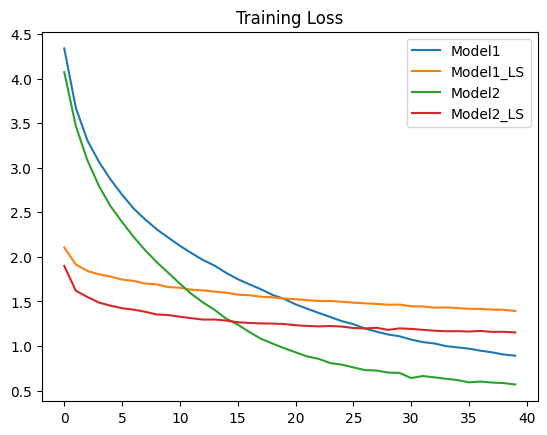

In [28]:

#Plot the loss
plt.figure()
plt.plot(train_loss, label='Model1')
plt.plot(train_loss_ls, label='Model1_LS')
plt.plot(train_loss2, label='Model2')
plt.plot(train_loss2_ls, label='Model2_LS')
plt.title('Training Loss')
plt.legend()
plt.show()


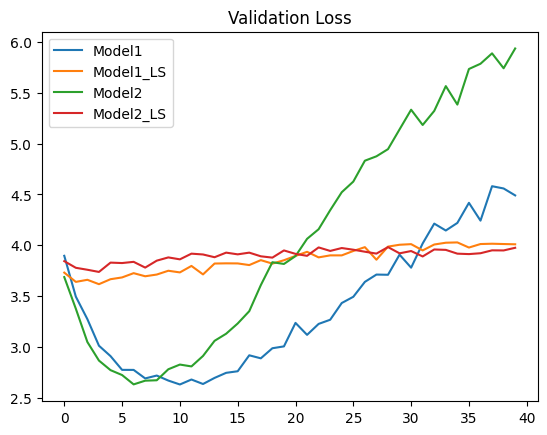

In [29]:
#Plot the validation accuracy of the models
plt.figure()
plt.plot(val_loss, label='Model1')
plt.plot(val_loss_ls, label='Model1_LS')
plt.plot(val_loss2, label='Model2')
plt.plot(val_loss2_ls, label='Model2_LS')
plt.title('Validation Loss')
plt.legend()
plt.show()



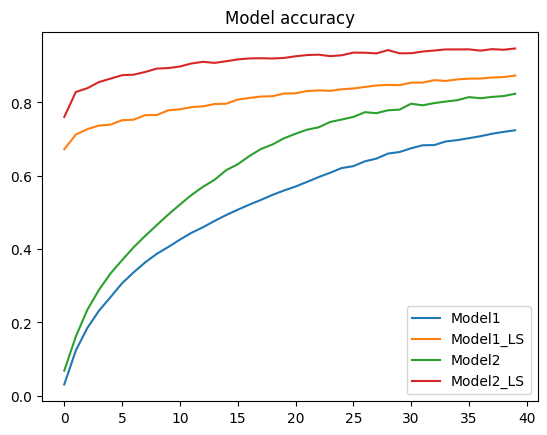

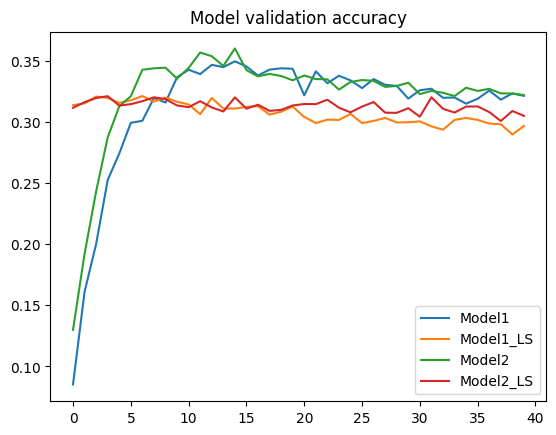

In [34]:
#plot the accuracy (train accuracy and validation accuracy) of the models
plt.figure()
plt.plot(history.history['accuracy'], label='Model1')
plt.plot(history_ls.history['accuracy'], label='Model1_LS')
plt.plot(history2.history['accuracy'], label='Model2')

plt.plot(history2_ls.history['accuracy'], label='Model2_LS')
plt.title('Model accuracy')
plt.legend()
plt.show()

#plot the validation accuracy of the models
plt.figure()
plt.plot(history.history['val_accuracy'], label='Model1')
plt.plot(history_ls.history['val_accuracy'], label='Model1_LS')
plt.plot(history2.history['val_accuracy'], label='Model2')

plt.plot(history2_ls.history['val_accuracy'], label='Model2_LS')
plt.title('Model validation accuracy')
plt.legend()
plt.show()




## Save the trained Model

In [31]:
#save the trained model (Parameters) so I can use it again without training again
model.save('model1.h5')
model2.save('model2.h5')

#save the histories
np.save('history.npy', history.history)
np.save('history_ls.npy', history_ls.history)
np.save('history2.npy', history2.history)
np.save('history2_ls.npy', history2_ls.history)



## Load the trained Model

In [ ]:
#load the model
# model = keras.models.load_model('model1.h5')
# model2 = keras.models.load_model('model2.h5')

#load the histories
# history = np.load('history.npy', allow_pickle='TRUE').item()
# history_ls = np.load('history_ls.npy', allow_pickle='TRUE').item()
# history2 = np.load('history2.npy', allow_pickle='TRUE').item()
# history2_ls = np.load('history2_ls.npy', allow_pickle='TRUE').item()
